# Inspecting Features of Flights within Airspace

European FIRs

In [107]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import pandas as pd

import os
import sys

# Get the current directory
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'turning_scripts'))

from data_preambles import dtypes_no_id, col_names, csv_to_exclude, catalog_col_names
from path_prefix import PATH_PREFIX



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


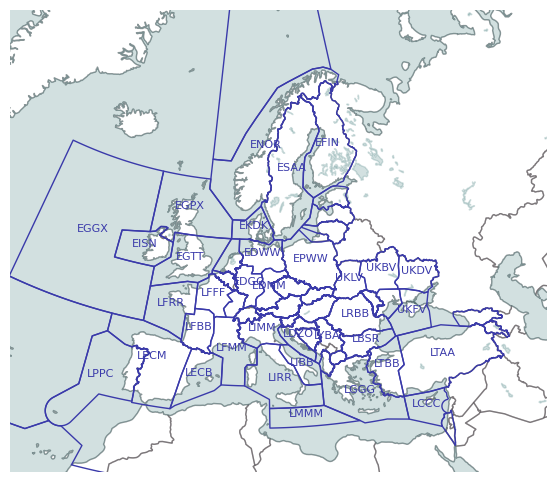

In [108]:
import matplotlib.pyplot as plt

from cartes.crs import LambertConformal
from cartes.utils.features import countries, lakes, ocean
from traffic.data import eurofirs

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw=dict(projection=LambertConformal(10, 45)),
)

ax.set_extent((-20, 45, 25, 75))

ax.add_feature(countries(scale="50m"))
ax.add_feature(lakes(scale="50m"))
ax.add_feature(ocean(scale="50m"))

ax.spines['geo'].set_visible(False)

for fir in eurofirs:
    fir.plot(ax, edgecolor="#3a3aaa")
    if fir.designator not in ["ENOB", "LPPO", "GCCC"] and fir.area > 1e11:
        fir.annotate(
            ax,
            s=fir.designator,
            ha="center",
            color="#3a3aaa",
            fontsize=8,
        )

Now we load up some flight segments and compute some features related to the airspace

In [110]:
import pandas as pd 

df = pd.read_csv(f'{PATH_PREFIX}/data/hourly/1716771600.csv')
# df columns: 'id', 'time', 'from_lat', 'from_lon', 'to_lat', 'to_lon'
df.head()

,id,time,from_lat,from_lon,to_lat,to_lon
0,461f31FIN7PY,1.716772e+09,37.884723,30.696816,37.937347,30.701177
1,461f31FIN7PY,1.716772e+09,37.937347,30.701177,38.326271,30.920662
2,461f31FIN7PY,1.716772e+09,38.326271,30.920662,38.591309,30.948845
3,461f31FIN7PY,1.716772e+09,38.591309,30.948845,42.245728,29.065580
4,461f31FIN7PY,1.716774e+09,42.245728,29.065580,44.280899,26.873866


In [111]:
def get_fir_polygon(fir_name):
    """
    Get FIR polygon from traffic.data eurofirs.
    
    Args:
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        shapely.geometry.Polygon: Polygon representing the FIR boundary
    """
    # Get FIR data from eurofirs
    fir = eurofirs.query(f"designator == '{fir_name}'")
    return fir.data.iloc[0].geometry

def filter_segments_by_fir(segments_df, fir_name):
    """
    Filter segments that have at least one endpoint within the specified FIR.
    
    Args:
        segments_df (pd.DataFrame): DataFrame containing segments with columns 
            [from_lat, from_lon, to_lat, to_lon]
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        pd.DataFrame: Filtered DataFrame containing only segments with points inside the FIR
    """
    from shapely.geometry import Point
    from shapely.prepared import prep
    
    # Get FIR polygon from your FIR data source
    fir_polygon = get_fir_polygon(fir_name)  # You'll need to implement this
    prepared_polygon = prep(fir_polygon)  # Optimize for repeated contains checks
    
    def point_in_fir(lat, lon):
        point = Point(lon, lat)  # Note: Shapely uses (x,y) order (lon,lat)
        return prepared_polygon.contains(point)
    
    # Create mask for segments where either endpoint is inside the FIR
    mask = (
        segments_df.apply(lambda row: (
            point_in_fir(row['from_lat'], row['from_lon']) or 
            point_in_fir(row['to_lat'], row['to_lon'])
        ), axis=1)
    )
    
    # Return filtered DataFrame
    return segments_df[mask]

In [112]:
def count_segments_within_fir(segments_df, fir_name):
    """
    Count segments that have both endpoints within the specified FIR.
    
    Args:
        segments_df (pd.DataFrame): DataFrame containing segments with columns 
            [from_lat, from_lon, to_lat, to_lon]
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        int: Number of segments entirely within the FIR
    """
    from shapely.geometry import Point
    from shapely.prepared import prep
    
    # Get FIR polygon from your FIR data source
    fir_polygon = get_fir_polygon(fir_name)
    prepared_polygon = prep(fir_polygon)  # Optimize for repeated contains checks
    
    def point_in_fir(lat, lon):
        point = Point(lon, lat)  # Note: Shapely uses (x,y) order (lon,lat)
        return prepared_polygon.contains(point)
    
    # Create mask for segments where both endpoints are inside the FIR
    mask = (
        segments_df.apply(lambda row: (
            point_in_fir(row['from_lat'], row['from_lon']) and 
            point_in_fir(row['to_lat'], row['to_lon'])
        ), axis=1)
    )
    
    # Return filtered DataFrame with segments entirely within FIR
    return segments_df[mask]


In [113]:
# Visualize one airspace
fir_name = 'LFMM'
filtered_df = filter_segments_by_fir(df, fir_name)
filtered_df.head()

print(f'During one hour:')
print(f"- Number of segments in {fir_name}: {len(filtered_df)}")
print(f"- Number of unique flights in {fir_name}: {filtered_df['id'].nunique()}")
# Example usage
fir_name = 'LFMM'
segments_within = count_segments_within_fir(df, fir_name)
print(f"- Number of segments entirely within {fir_name}: {len(segments_within)}")
print(f"- Number of unique flights entirely within {fir_name}: {segments_within['id'].nunique()}")


During one hour:
- Number of segments in LFMM: 63
- Number of unique flights in LFMM: 26
- Number of segments entirely within LFMM: 38
- Number of unique flights entirely within LFMM: 18


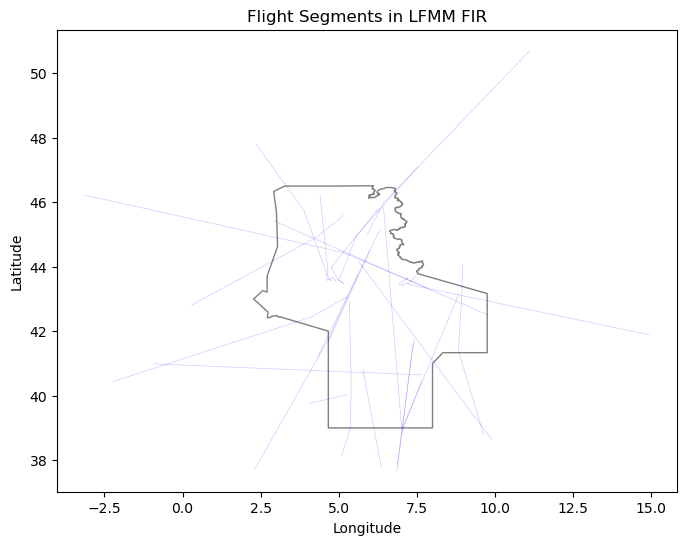

In [114]:
# Plot the FIR and the filtered segments
import matplotlib.pyplot as plt

# Get FIR polygon
fir_polygon = get_fir_polygon(fir_name)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments
# Sample 100 random segments
# sampled_df = filtered_df.sample(n=min(100, len(filtered_df)), random_state=42)
sampled_df = filtered_df
for _, row in sampled_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.2, linewidth=0.5)
    # # Plot from points in green and to points in red
    # ax.scatter(row['from_lon'], row['from_lat'], c='green', s=10, alpha=0.3)
    # ax.scatter(row['to_lon'], row['to_lat'], c='red', s=10, alpha=0.3)

# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Flight Segments in {fir_name} FIR')

plt.show()


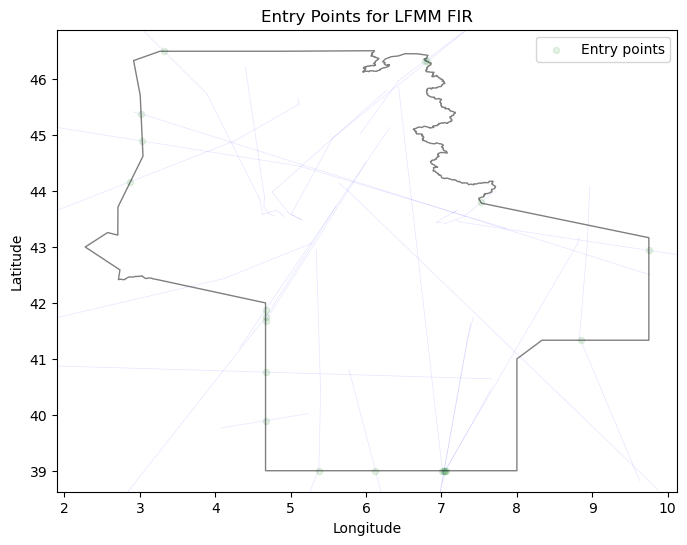

Number of entry points: 21


In [115]:
from shapely.geometry import LineString, Point
import numpy as np

def find_intersection_points(df, fir_polygon):
    entry_points = []
    exit_points = []
    
    for _, row in df.iterrows():
        # Create line segment from flight path
        line = LineString([(row['from_lon'], row['from_lat']), 
                         (row['to_lon'], row['to_lat'])])
        
        # If line intersects with FIR boundary
        if line.intersects(fir_polygon.boundary):
            # Get intersection point(s)
            intersection = line.intersection(fir_polygon.boundary)
            
            # Handle both single point and multiple points cases
            if intersection.geom_type == 'Point':
                points = [intersection]
            else:  # MultiPoint
                points = list(intersection.geoms)
            
            # Sort points by distance from start of segment
            points.sort(key=lambda p: LineString([(row['from_lon'], row['from_lat']), (p.x, p.y)]).length)
            
            # First point is entry, last point is exit
            if len(points) >= 1:
                if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                    # Flight starts inside FIR
                    exit_points.append((points[-1].x, points[-1].y))
                else:
                    # Flight starts outside FIR
                    entry_points.append((points[0].x, points[0].y))
                    
                if len(points) > 1:
                    if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                        # Flight starts inside FIR
                        entry_points.append((points[0].x, points[0].y))
                    else:
                        # Flight starts outside FIR
                        exit_points.append((points[-1].x, points[-1].y))

    return np.array(entry_points), np.array(exit_points)

# Get entry and exit points
entry_points, exit_points = find_intersection_points(filtered_df, fir_polygon)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments (optional, can be commented out if too cluttered)
for _, row in filtered_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.1, linewidth=0.5)

# Plot entry points in green and exit points in red
if len(entry_points) > 0:
    ax.scatter(entry_points[:, 0], entry_points[:, 1], 
              c='green', s=20, alpha=0.1, label='Entry points')
    
# Get bounds of FIR polygon
bounds = fir_polygon.bounds  # Returns (minx, miny, maxx, maxy)
# Add 5% margin to the bounds
margin_x = (bounds[2] - bounds[0]) * 0.05
margin_y = (bounds[3] - bounds[1]) * 0.05
ax.set_xlim(bounds[0] - margin_x, bounds[2] + margin_x)
ax.set_ylim(bounds[1] - margin_y, bounds[3] + margin_y)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Entry Points for {fir_name} FIR')
ax.legend()

plt.show()

print(f"Number of entry points: {len(entry_points)}")


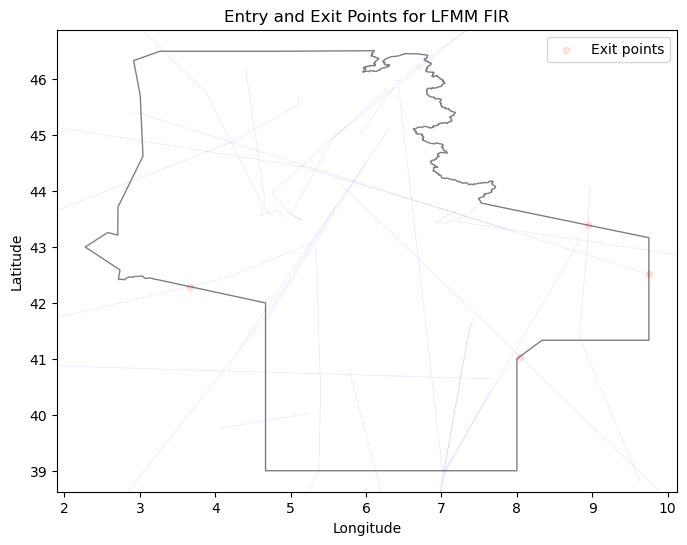

Number of exit points: 4


In [116]:
from shapely.geometry import LineString, Point
import numpy as np

def find_intersection_points(df, fir_polygon):
    entry_points = []
    exit_points = []
    
    for _, row in df.iterrows():
        # Create line segment from flight path
        line = LineString([(row['from_lon'], row['from_lat']), 
                         (row['to_lon'], row['to_lat'])])
        
        # If line intersects with FIR boundary
        if line.intersects(fir_polygon.boundary):
            # Get intersection point(s)
            intersection = line.intersection(fir_polygon.boundary)
            
            # Handle both single point and multiple points cases
            if intersection.geom_type == 'Point':
                points = [intersection]
            else:  # MultiPoint
                points = list(intersection.geoms)
            
            # Sort points by distance from start of segment
            points.sort(key=lambda p: LineString([(row['from_lon'], row['from_lat']), (p.x, p.y)]).length)
            
            # First point is entry, last point is exit
            if len(points) >= 1:
                if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                    # Flight starts inside FIR
                    exit_points.append((points[-1].x, points[-1].y))
                else:
                    # Flight starts outside FIR
                    entry_points.append((points[0].x, points[0].y))
                    
                if len(points) > 1:
                    if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                        # Flight starts inside FIR
                        entry_points.append((points[0].x, points[0].y))
                    else:
                        # Flight starts outside FIR
                        exit_points.append((points[-1].x, points[-1].y))

    return np.array(entry_points), np.array(exit_points)

# Get entry and exit points
entry_points, exit_points = find_intersection_points(filtered_df, fir_polygon)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments (optional, can be commented out if too cluttered)
for _, row in filtered_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.1, linewidth=0.5)

# Plot entry points in green and exit points in red
if len(entry_points) > 0:
    ax.scatter(exit_points[:, 0], exit_points[:, 1], 
              c='red', s=20, alpha=0.1, label='Exit points')
    
# Get bounds of FIR polygon
bounds = fir_polygon.bounds  # Returns (minx, miny, maxx, maxy)
# Add 5% margin to the bounds
margin_x = (bounds[2] - bounds[0]) * 0.05
margin_y = (bounds[3] - bounds[1]) * 0.05
ax.set_xlim(bounds[0] - margin_x, bounds[2] + margin_x)
ax.set_ylim(bounds[1] - margin_y, bounds[3] + margin_y)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Entry and Exit Points for {fir_name} FIR')
ax.legend()

plt.show()

print(f"Number of exit points: {len(exit_points)}")


In [140]:
# Plot one flight
df_id = filtered_df['id'].unique()[23]
df_id_df = filtered_df[filtered_df['id'] == df_id]
# Sort the flight segments by time
df_id_df = df_id_df.sort_values('time')



df_id_df.head()

,id,time,from_lat,from_lon,to_lat,to_lon
2091,4520cfCFG6PK,1.716773e+09,41.197753,4.322246,45.138062,6.314457


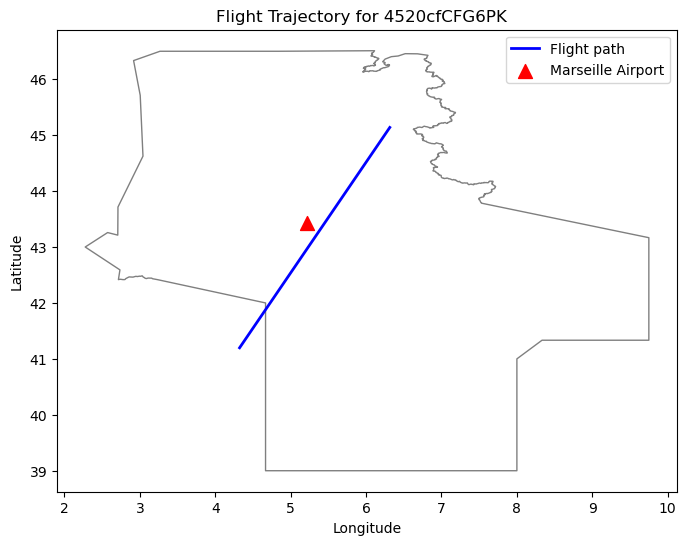

In [141]:
# Create a new figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon as background reference
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot the trajectory
ax.plot(df_id_df['from_lon'].tolist() + [df_id_df['to_lon'].iloc[-1]], 
        df_id_df['from_lat'].tolist() + [df_id_df['to_lat'].iloc[-1]], 
        'b-', linewidth=2, label='Flight path')

# Add Marseille Airport coordinates
marseille_coords = (5.2145, 43.4365)  # (lon, lat)
ax.scatter(marseille_coords[0], marseille_coords[1], 
          c='red', marker='^', s=100, label='Marseille Airport')


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Flight Trajectory for {df_id}')
ax.legend()

plt.show()
